Dataset: wiki_machine_learning.csv

Description: Data represents how many times Wikipedia page of Machine Learning was read during
some period of time. The data is presented in csv format as follows: date, count, lang, page, rank,
month, title. Null values of count column are identified with 0, please remove them while
preprocessing.

Task: You are asked to create a model using Facebook Prophet and Neural Prophet algorithms to
predict how many times the article will read for the future 30 days (count column).

In [142]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import numpy as np
import pandas as pd

import datetime
import random as rd
import statsmodels.api as sm

from fbprophet import Prophet

import statsmodels.tsa.api as smt
import statsmodels.api as sn
from statsmodels.tsa.stattools import adfuller

In [143]:
data=pd.read_csv("wiki_machine_learning.csv", sep=" ", parse_dates=["date"],na_values=0)

In [144]:
data

,date,count,lang,page,rank,month,title
81,2015-01-01,1414.0,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920.0,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338.0,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404.0,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264.0,en,Machine_learning,8708,201501,Machine_learning
...,...,...,...,...,...,...,...
382,2016-01-16,1644.0,en,Machine_learning,8708,201601,Machine_learning
381,2016-01-17,1836.0,en,Machine_learning,8708,201601,Machine_learning
376,2016-01-18,2983.0,en,Machine_learning,8708,201601,Machine_learning
375,2016-01-19,3389.0,en,Machine_learning,8708,201601,Machine_learning


In [145]:
data.columns

Index(['date', 'count', 'lang', 'page', 'rank', 'month', 'title'], dtype='object')

In [146]:
for c in data.columns[1:]:
  print (c)
  print(data[c].unique(),'\n')

count
[1414. 1920. 1338. 1404. 2264. 2327. 2469. 2349. 2279. 1600. 1539. 2581.
 2678. 2584. 2485. 2336. 1384. 1556. 2612. 2860. 2571. 2697. 2232. 1280.
 1690. 2501. 2680. 2737. 2671. 2261. 1125. 1486. 2580. 2630. 2685.   nan
 2395. 1679. 1691. 2617. 3047. 2530. 2393. 1333. 1356. 2236. 2312. 2386.
 2402. 2253. 1638. 1614. 2592. 2747. 2633. 2606. 2351. 1645. 1688. 2792.
 2857. 2659. 2566. 2214. 1432. 2004. 2668. 2576. 2670. 2565. 2399. 1651.
 1732. 4848. 2608. 2505. 2302. 1565. 1760. 2895. 2877. 2757. 2492. 2527.
 1578. 1660. 2666. 2809. 2412. 2403. 1849. 1422. 1508. 2518. 3174. 2800.
 2929. 2702. 1722. 2002. 3428. 4881. 2804. 3217. 2384. 1482. 1816. 2819.
 2994. 2811. 2370. 1487. 1696. 2526. 2782. 2799. 2543. 1670. 1794. 2802.
 2840. 3005. 2714. 1697. 2718. 2837. 2908. 4932. 2813. 1634. 1725. 2870.
 2832. 2864. 2681. 1390. 1618. 2086. 2699. 2711. 2649. 2277. 1576. 1724.
 2713. 2808. 2720. 2742. 2467. 1582. 2703. 2765. 2833. 2911. 2464. 1435.
 1599. 2069. 1769. 1569. 1418. 1294.  729.  7

In [147]:
data.isnull().sum()

date     0
count    1
lang     0
page     0
rank     0
month    0
title    0
dtype: int64

In [148]:
df=data.dropna()

In [149]:
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414.0,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920.0,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338.0,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404.0,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264.0,en,Machine_learning,8708,201501,Machine_learning


In [150]:
df.drop(df.columns[2:],axis=1,inplace=True)

In [151]:
df

,date,count
81,2015-01-01,1414.0
80,2015-01-02,1920.0
79,2015-01-03,1338.0
78,2015-01-04,1404.0
77,2015-01-05,2264.0
...,...,...
382,2016-01-16,1644.0
381,2016-01-17,1836.0
376,2016-01-18,2983.0
375,2016-01-19,3389.0


In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_A = seasonal_decompose(df['count'].values,freq=30, model='additive')
result_M = seasonal_decompose(df['count'].values,freq=30, model = 'multiplicative')

(<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>)

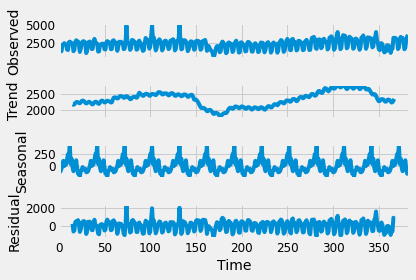

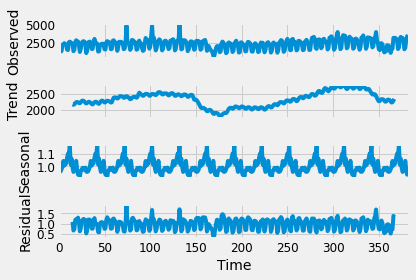

In [153]:
result_A.plot(),result_M.plot()

In [154]:
def st_check(timeseries):
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
  
st_check(df['count'])

Test statistic                  -3.288864
p-value                          0.015384
#Lags Used                      15.000000
Number of Observations Used    367.000000
Critical Value (1%)             -3.448294
Critical Value (5%)             -2.869448
Critical Value (10%)            -2.570983
dtype: float64


In [155]:
print("\n" ,"start date:",df.date.min(), "\n",
      "end_date:" , df.date.max(),"\n",
      "days in range:", (df.date.max()-df.date.min()).days) 


 start date: 2015-01-01 00:00:00 
 end_date: 2016-01-20 00:00:00 
 days in range: 384


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 81 to 372
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    383 non-null    datetime64[ns]
 1   count   383 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.0+ KB


# Facebook Prophet

In [157]:
from fbprophet import Prophet

In [158]:
proph=df[['date', 'count']].rename(columns={'date': "ds", "count": "y"})

In [159]:
proph.head()

,ds,y
81,2015-01-01,1414.0
80,2015-01-02,1920.0
79,2015-01-03,1338.0
78,2015-01-04,1404.0
77,2015-01-05,2264.0


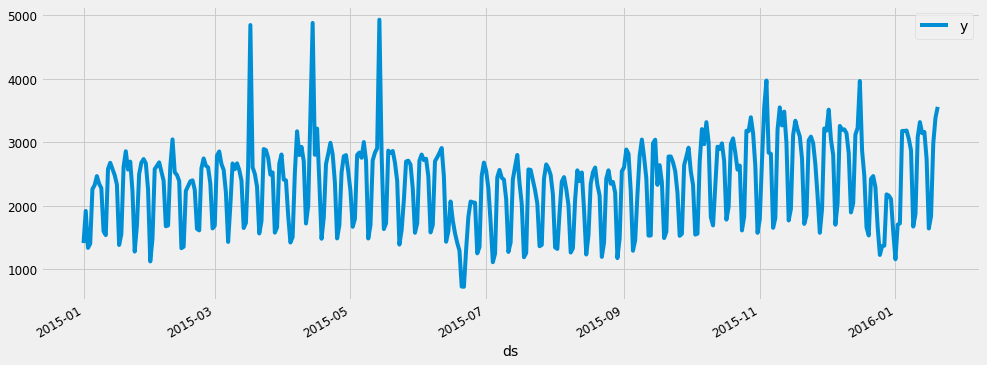

In [160]:
proph.plot(figsize=(15, 6), y='y', x='ds')
plt.show()

In [161]:
model=Prophet(interval_width=0.95)
model.fit(proph)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [162]:
data_future=model.make_future_dataframe(periods=30)
data_forecast=model.predict(data_future)

In [163]:
data_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
408,2016-02-15,2962.938018,2299.586107,3671.069843
409,2016-02-16,3201.427330,2532.645578,3884.345006
410,2016-02-17,3094.002469,2409.770236,3794.060044
411,2016-02-18,2972.401025,2275.331699,3697.435539
412,2016-02-19,2651.411303,1990.693478,3382.599313


Text(0.5, 1.0, 'WIKIPEDIA ML Articles')

<Figure size 1152x576 with 0 Axes>

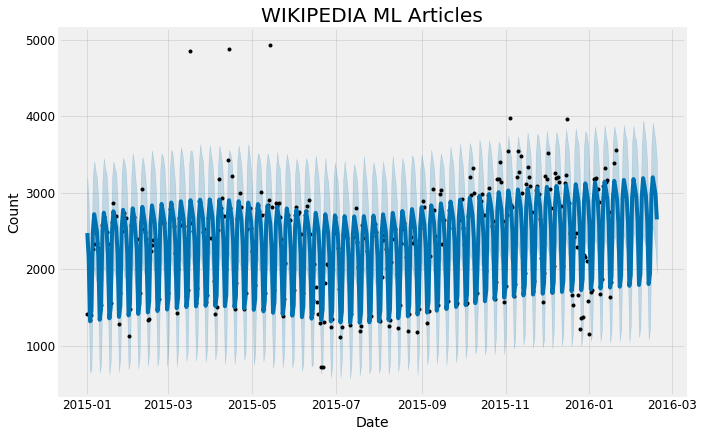

In [164]:
plt.figure(figsize = (16,8))
model.plot(pred, xlabel = 'Date', ylabel = 'Count')
plt.title('WIKIPEDIA ML Articles')

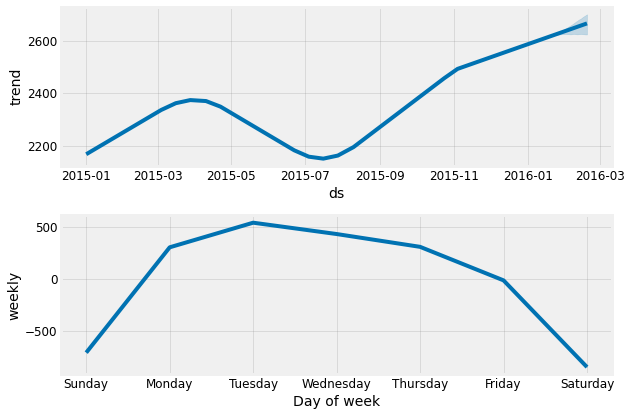

In [165]:
fig = model.plot_components(pred)

# Neural Prophet

In [166]:
# pip install neuralprophet

In [167]:
from neuralprophet import NeuralProphet

In [168]:
proph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 81 to 372
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      383 non-null    datetime64[ns]
 1   y       383 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.0+ KB


In [169]:
test_length = 80
df_train = proph.iloc[:-test_length]
df_test = proph.iloc[-test_length:]

In [176]:
np_model = NeuralProphet()
metrics = np_model.fit(df_train, freq="D")
np_future_df = np_model.make_future_dataframe(df_train, 
                                                 periods = test_length, 
                                                 n_historic_predictions=len(df_train))
np_preds_df = np_model.predict(np_future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.01% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True t

  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 6.54E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-01, min: 6.54E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.27E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.44E-01, min: 1.27E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.27E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.27E-01
Epoch[301/301]: 100%|██████████| 301/301 [00:17<00:00, 17.65it/s, SmoothL1Loss=0.00775, MAE=175, RMSE=259, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.01% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.217% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.217% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to ma

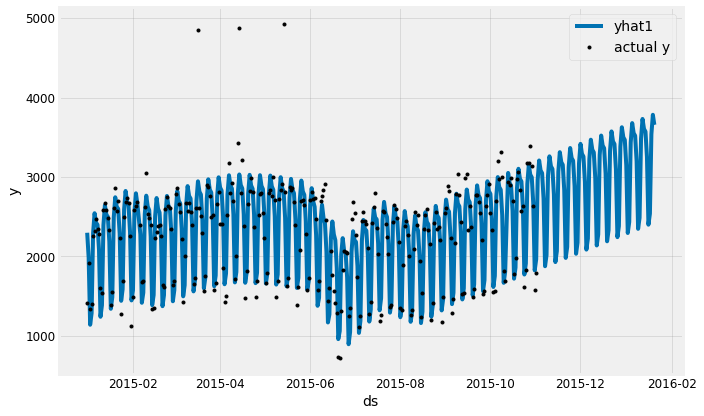

In [180]:
np_model.plot(np_preds_df)
plt.show()

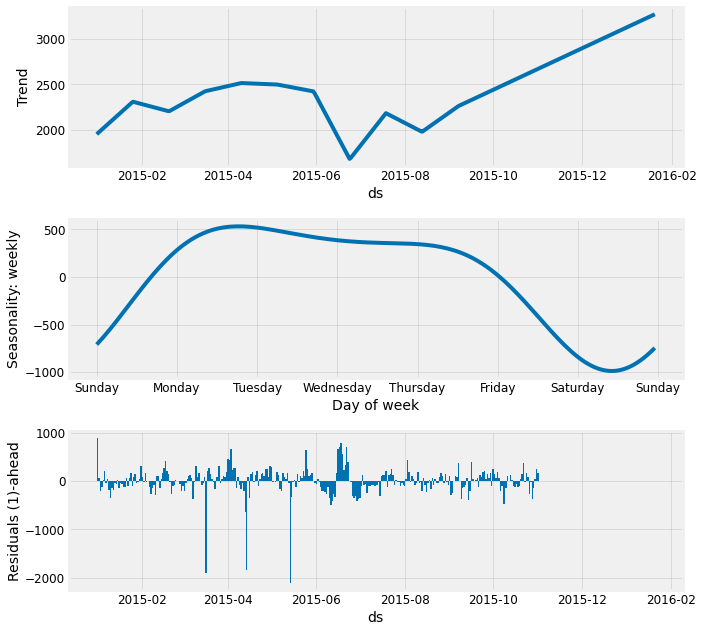

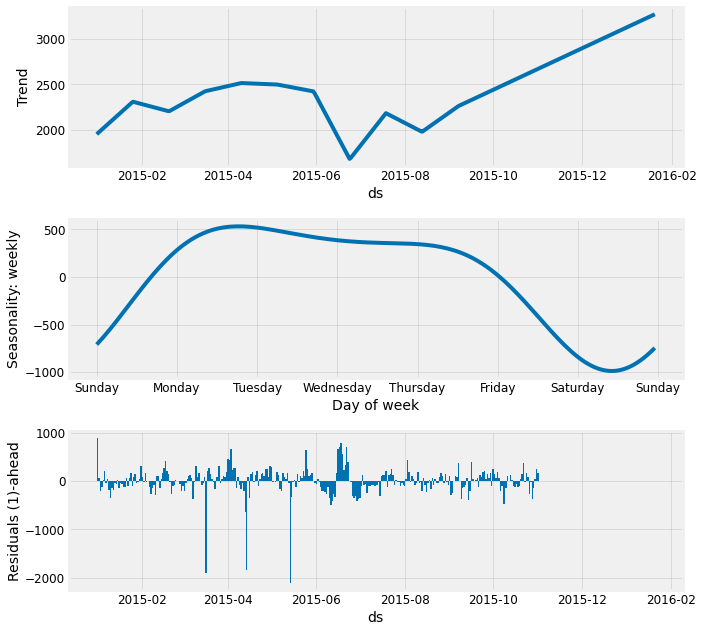

In [181]:
np_model.plot_components(np_preds_df, residuals=True)

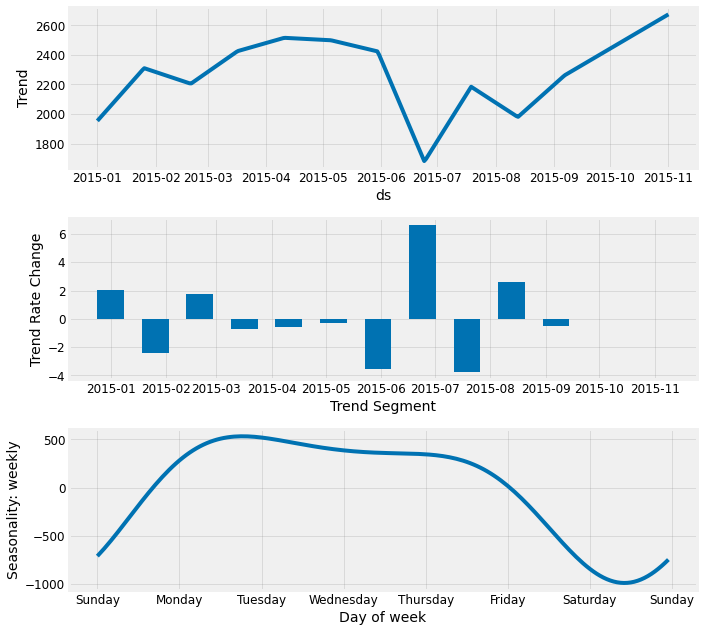

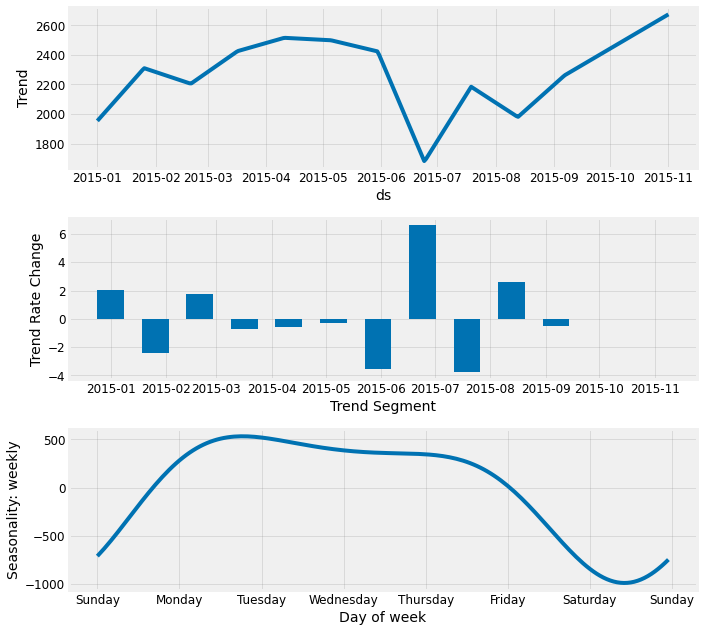

In [182]:
np_model.plot_parameters()

In [177]:
from sklearn.metrics import mean_squared_error
print(f"NeuralProphet:\t{mean_squared_error(df_test['y'], np_preds_df.iloc[-test_length:]['yhat1']):.4f}")

NeuralProphet:	439583.2902


In [183]:
df

,date,count
81,2015-01-01,1414.0
80,2015-01-02,1920.0
79,2015-01-03,1338.0
78,2015-01-04,1404.0
77,2015-01-05,2264.0
...,...,...
382,2016-01-16,1644.0
381,2016-01-17,1836.0
376,2016-01-18,2983.0
375,2016-01-19,3389.0


In [186]:
data_future_np=np_model.make_future_dataframe(df_test,periods=100)
data_forecast_np=np_model.predict(data_future_np)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.75% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


In [187]:
data_forecast_np.head()

,ds,y,yhat1,residual1,trend,season_weekly
0,2016-01-21,None,3625.483643,NaN,3279.978760,345.504852
1,2016-01-22,None,3305.726807,NaN,3287.452148,18.274473
2,2016-01-23,None,2452.855957,NaN,3294.925781,-842.069641
3,2016-01-24,None,2592.125977,NaN,3302.399170,-710.272949
4,2016-01-25,None,3592.245361,NaN,3309.872559,282.372803


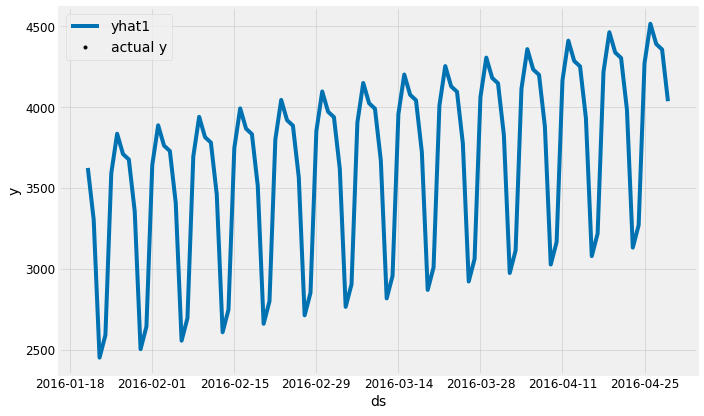

In [188]:
fig3=nprophet_model.plot(data_forecast_np)
plt.show()